In [7]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [8]:
dataset_path = "/content/drive/MyDrive/Colab Notebooks/data.pkl"
print(dataset_path)

/content/drive/MyDrive/Colab Notebooks/data.pkl


In [9]:
import pickle
with open(dataset_path, 'rb') as file:
    data = pickle.load(file)

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
(train_imgs, train_labels), (val_imgs, val_labels) = data

train_imgs = train_imgs.astype('float32') / 255.0
val_imgs = val_imgs.astype('float32') / 255.0

print(f"Training images shape: {train_imgs.shape}")
print(f"Training labels shape: {train_labels.shape}")
print(f"Validation images shape: {val_imgs.shape}")
print(f"Validation labels shape: {val_labels.shape}")

Training images shape: (5728, 256, 256, 3)
Training labels shape: (5728,)
Validation images shape: (1432, 256, 256, 3)
Validation labels shape: (1432,)


In [12]:
from tensorflow.keras.utils import to_categorical

# Convert labels to one-hot encoding
train_labels_hot = to_categorical(train_labels, num_classes=4)
val_labels_hot = to_categorical(val_labels, num_classes=4)


In [13]:
class_names = ['ashfaq', 'khalid', 'rifat', 'shafin']

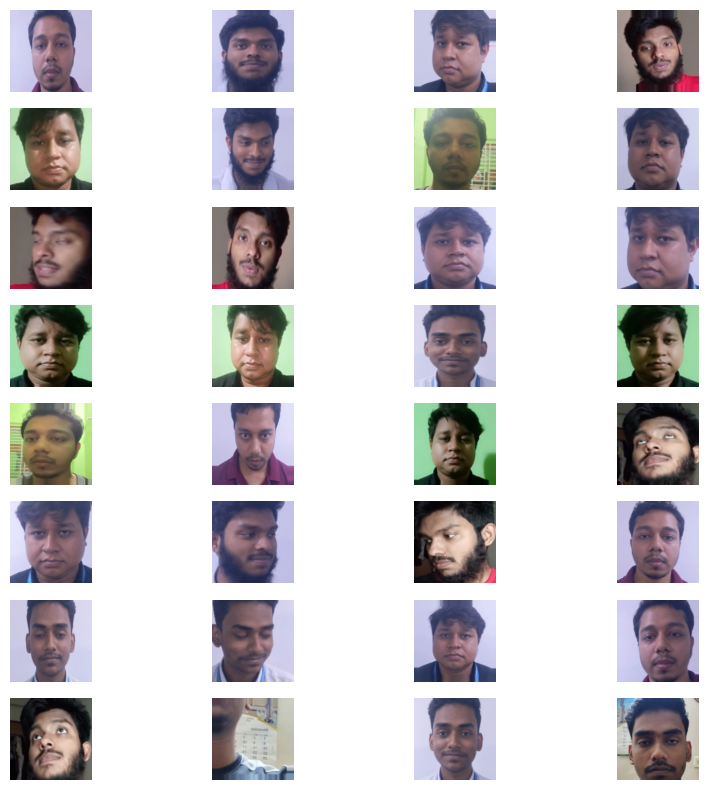

In [14]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
datagen.fit(train_imgs)

# Generate a batch of augmented images from the datagen
augmented_images, _ = next(datagen.flow(train_imgs, train_labels_hot, batch_size=32))

plt.figure(figsize=(10, 10))

for i in range(32):
    plt.subplot(8, 4, i + 1)
    plt.imshow(augmented_images[i])
    plt.axis('off')

plt.show()

In [15]:
from tensorflow.keras import models, layers, applications, optimizers

# Load a pre-trained model (e.g., MobileNetV2) without the top classification layer
base_model = applications.MobileNetV2(
    input_shape=(256, 256, 3),  # Input shape for your images
    include_top=False,          # Exclude the top classification layer
    weights='imagenet'          # Load weights pre-trained on ImageNet
)

# Freeze the base model to prevent its weights from being updated during training
base_model.trainable = False

# Create the transfer learning model
model = models.Sequential([
    # Pre-trained base model
    base_model,

    # Add custom layers for face recognition
    layers.GlobalAveragePooling2D(),  # Global average pooling to reduce dimensions
    layers.Dense(128, activation='relu'),  # Dense layer for feature extraction
    layers.Dropout(0.5),  # Dropout for regularization
    layers.Dense(4, activation='softmax')  # Output layer for 4 classes
])

# Unfreeze the top layers of the base model
base_model.trainable = True

# Fine-tune only the last few layers of the base model
for layer in base_model.layers[:-10]:
    layer.trainable = False

# Recompile the model with a lower learning rate
model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-5),  # Lower learning rate for fine-tuning
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Print the updated model summary
model.summary()

<ipython-input-15-d0a058003db7>:4: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = applications.MobileNetV2(


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 8, 8, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         163,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,422,468 (9.24 MB)

 Trainable params: 896,964 (3.42 MB)

 Non-trainable params: 1,525,504 (5.82 MB)

In [16]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(
    datagen.flow(train_imgs, train_labels_hot, batch_size=6),
    epochs=50,
    validation_data=(val_imgs, val_labels_hot),
    callbacks=[early_stopping],
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
955/955 ━━━━━━━━━━━━━━━━━━━━ 124s 115ms/step - accuracy: 0.5926 - loss: 0.9843 - val_accuracy: 0.9581 - val_loss: 0.2079
Epoch 2/50
955/955 ━━━━━━━━━━━━━━━━━━━━ 89s 93ms/step - accuracy: 0.9352 - loss: 0.2614 - val_accuracy: 0.9937 - val_loss: 0.0401
Epoch 3/50
955/955 ━━━━━━━━━━━━━━━━━━━━ 88s 92ms/step - accuracy: 0.9553 - loss: 0.1662 - val_accuracy: 0.9958 - val_loss: 0.0167
Epoch 4/50
955/955 ━━━━━━━━━━━━━━━━━━━━ 88s 92ms/step - accuracy: 0.9652 - loss: 0.1092 - val_accuracy: 0.9986 - val_loss: 0.0102
Epoch 5/50
955/955 ━━━━━━━━━━━━━━━━━━━━ 89s 93ms/step - accuracy: 0.9791 - loss: 0.0792 - val_accuracy: 0.9986 - val_loss: 0.0065
Epoch 6/50
955/955 ━━━━━━━━━━━━━━━━━━━━ 87s 91ms/step - accuracy: 0.9819 - loss: 0.0684 - val_accuracy: 0.9986 - val_loss: 0.0048
Epoch 7/50
955/955 ━━━━━━━━━━━━━━━━━━━━ 88s 92ms/step - accuracy: 0.9872 - loss: 0.0554 - val_accuracy: 0.9993 - val_loss: 0.0040
Epoch 8/50
955/955 ━━━━━━━━━━━━━━━━━━━━ 89s 93ms/step - accuracy: 0.9849 - loss: 0.0504 

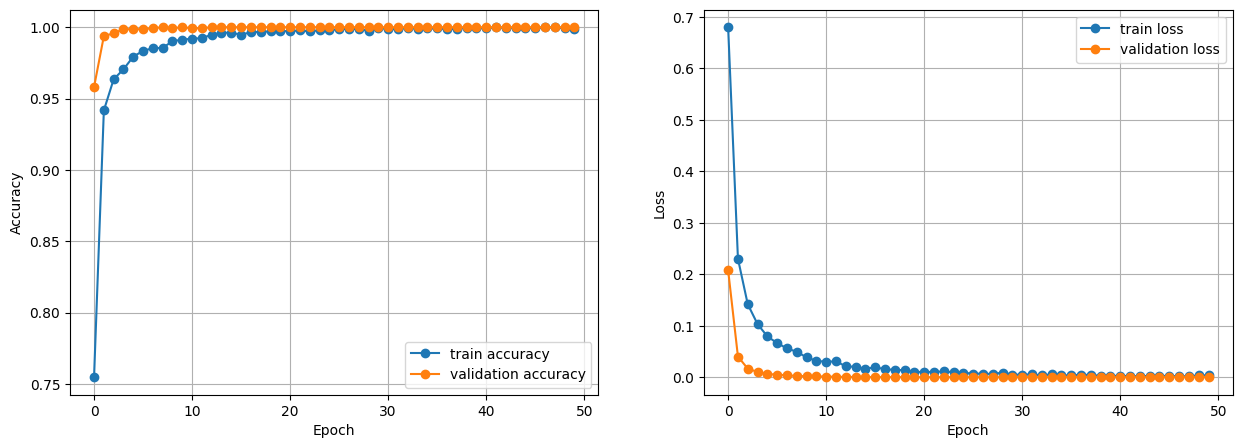

In [17]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], 'o-', label='train accuracy')
plt.plot(history.history['val_accuracy'], 'o-', label = 'validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend(loc='lower right')

plt.subplot(1,2,2)
plt.plot(history.history['loss'], 'o-', label='train loss')
plt.plot(history.history['val_loss'], 'o-', label='validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend(loc='upper right')

plt.show()

In [18]:
predictions = model.predict(val_imgs)

45/45 ━━━━━━━━━━━━━━━━━━━━ 9s 111ms/step


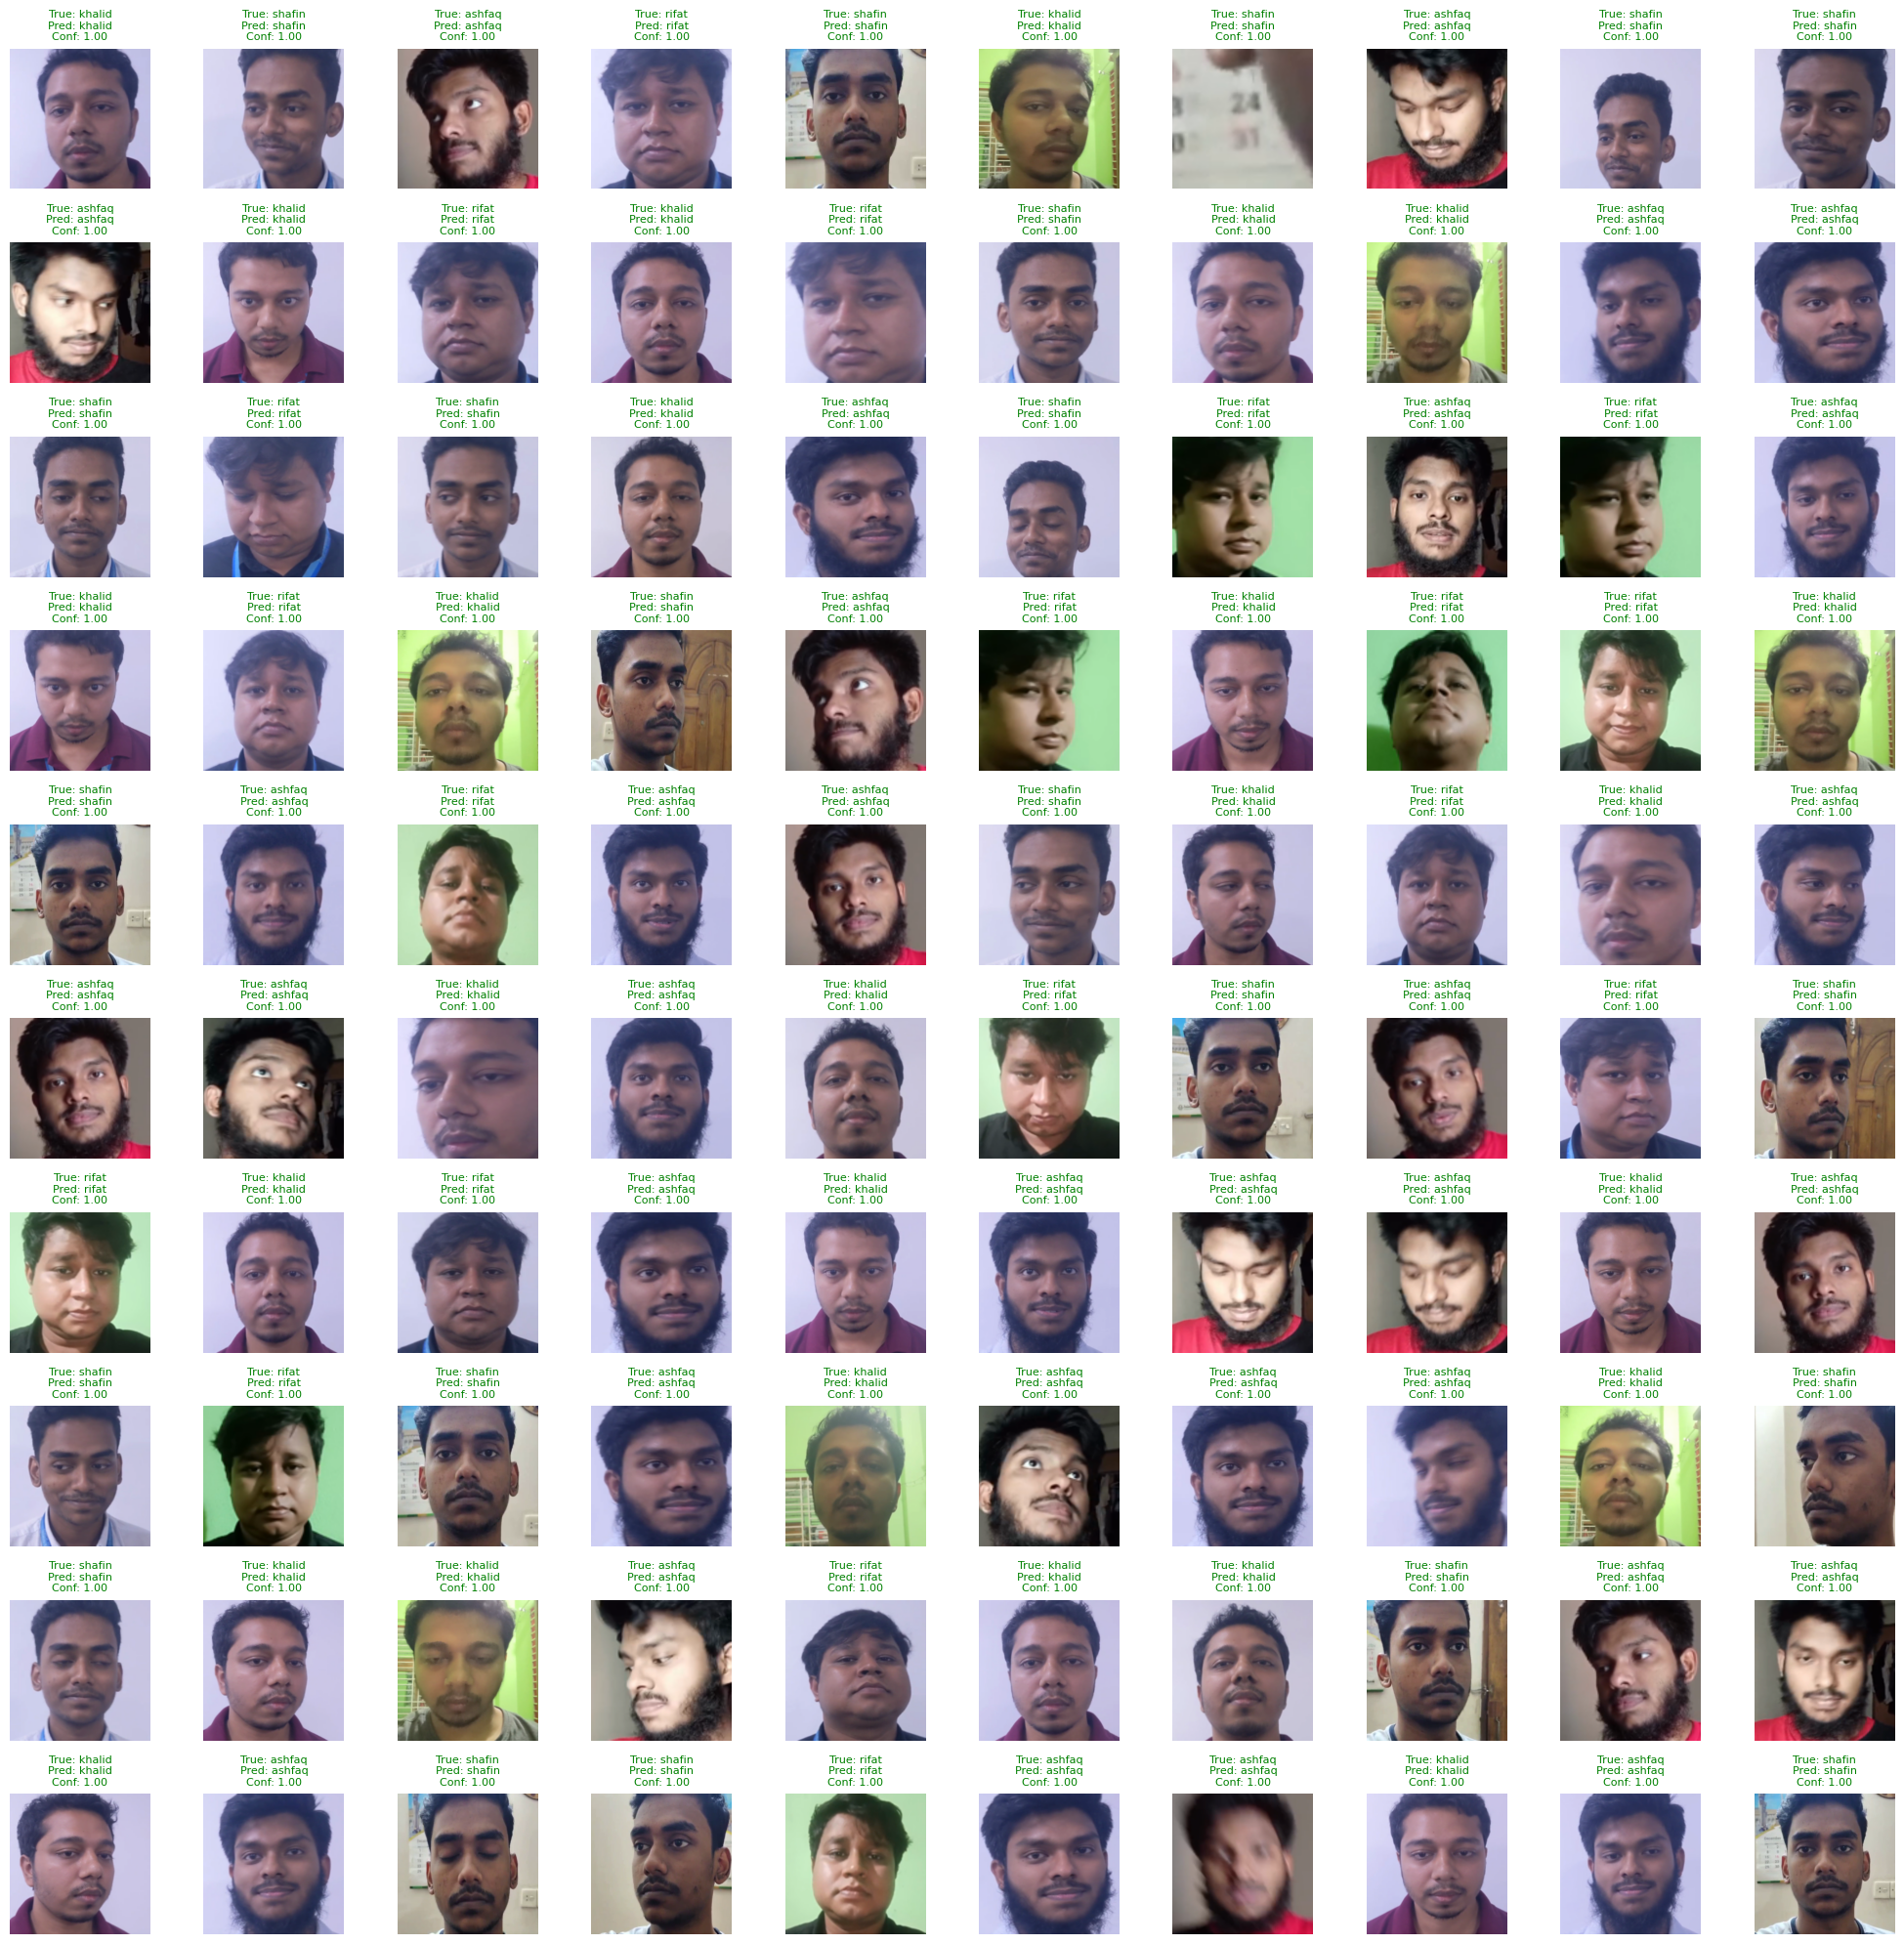

In [19]:
predicted_classes = np.argmax(predictions, axis=1)
confidence_levels = np.max(predictions, axis=1)

fig, axes = plt.subplots(10, 10, figsize=(20, 20))
axes = axes.ravel()

for i in range(100):
    axes[i].imshow(val_imgs[i])
    axes[i].axis('off')

    true_label = class_names[val_labels[i]]
    predicted_label = class_names[predicted_classes[i]]
    confidence = confidence_levels[i]

    color = "green" if predicted_classes[i] == val_labels[i] else "red"

    axes[i].set_title(f"True: {true_label}\nPred: {predicted_label}\nConf: {confidence:.2f}", color=color, fontsize=8)

plt.tight_layout()
plt.show()


In [20]:
model.save('face_recognition_model.keras')

In [22]:
with open('class_labels.pkl', 'wb') as file:
    pickle.dump(class_names, file)

In [ ]:
from google.colab.patches import cv2_imshow
import cv2
import numpy as np
import pickle
from tensorflow.keras.models import load_model  # type: ignore

# Load the trained face recognition model
model = load_model('face_recognition_model.keras')

# Load class labels from the pickle file
with open('class_labels.pkl', 'rb') as f:
    class_names = pickle.load(f)

# Load the Haar Cascade for face detection
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# Define padding percentage
padding_ratio = 0.2

# Initialize webcam
webcam = cv2.VideoCapture(0)

while True:
    # Capture frame-by-frame
    ret, frame = webcam.read()

    # Detect faces in the original color frame
    faces = face_cascade.detectMultiScale(frame, minNeighbors=10, minSize=(100, 100))

    # Loop over detected faces
    for (x, y, w, h) in faces:
        # Calculate padding
        pad_x = int(w * padding_ratio)
        pad_y = int(h * padding_ratio)

        # Expand the bounding box
        x1 = max(x - pad_x, 0)
        y1 = max(y - pad_y, 0)
        x2 = min(x + w + pad_x, frame.shape[1])
        y2 = min(y + h + pad_y, frame.shape[0])

        # Extract the face
        face_img = frame[y1:y2, x1:x2]

        # Preprocess the face image
        face_img_resized = cv2.resize(face_img, (256, 256))
        face_img_array = np.expand_dims(face_img_resized / 255.0, axis=0)

        # Get predictions
        predictions = model.predict(face_img_array)
        predicted_class = np.argmax(predictions)
        confidence = np.max(predictions)

        if confidence > 0.8:
            class_name = class_names[predicted_class]
            color = (0, 255, 0)  # Green
        else:
            class_name = 'No Prediction'
            color = (0, 0, 255)  # Red

        # Draw the bounding box and label
        cv2.rectangle(frame, (x1, y1), (x2, y2), color, 2)
        cv2.putText(frame, f'{class_name} ({confidence:.2f})', (x1, y1 - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.9, color, 2)



# Your existing loop
while True:
    # Your image processing code
    cv2_imshow(frame)  # Ensure this line is properly indented



    # Break if 'q' is pressed
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release resources
webcam.release()
cv2.destroyAllWindows()